# Multi-vehicle Rendezvous Problem

The dynamics model of an omnidirectional vehicle with friction coefficient $\alpha$ is defined by the following equation:

$$
m \dot{\textbf{v}} = \textbf{u} - \alpha \textbf{v}
$$

PDDP is applied to a two vehicle system in order to control them to gently collide with each other with a terminal velocity of $0 \frac{m}{s}$.

The state vector $\textbf{x}$ is defined as follows: $$\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x_0 & y_0 & x_1 & y_1 & \dot{x}_0 & \dot{y}_0 & \dot{x}_1 & \dot{y}_1
    \end{bmatrix}
\end{equation*}$$

The action vector $\textbf{u}$ is defined as follows: $$\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x_0} & F_{y_0} & F_{x_1} & F_{y_1}
    \end{bmatrix}
\end{equation*}$$

**Note**: That since this dynamics model is linear, this problem can be solved more efficiently with a simple Linear Quadratic Regulator (LQR) instead.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pddp
import pddp.examples

In [5]:
import numpy as np
import torch

In [6]:
N = 200  # Horizon length.
DT = 0.1  # Time step (s).
RENDER = True  # Whether to render the environment or not.

# Disable uncertainty since we are dealing with known dynamics.
ENCODING = pddp.StateEncoding.IGNORE_UNCERTAINTY

In [7]:
cost = pddp.examples.rendezvous.RendezvousCost()
model = pddp.examples.rendezvous.RendezvousDynamicsModel(DT)
env = pddp.examples.rendezvous.RendezvousEnv(dt=DT, render=RENDER)

In [8]:
def plot(Z, U):
    t = np.arange(N + 1) * DT
   
    X = Z.detach().numpy()
    U = U.detach().numpy()

    x_0 = X[:, 0]
    y_0 = X[:, 1]
    x_1 = X[:, 2]
    y_1 = X[:, 3]
    x_0_dot = X[:, 4]
    y_0_dot = X[:, 5]
    x_1_dot = X[:, 6]
    y_1_dot = X[:, 7]

    plt.figure()
    plt.title("Trajectory of the two omnidirectional vehicles")
    plt.plot(x_0, y_0, "r")
    plt.plot(x_1, y_1, "b")
    plt.legend(["Vehicle 1", "Vehicle 2"])

    plt.figure()
    plt.plot(t, x_0, "r")
    plt.plot(t, x_1, "b")
    plt.xlabel("Time (s)")
    plt.ylabel("x (m)")
    plt.title("X positional paths")
    plt.legend(["Vehicle 1", "Vehicle 2"])

    plt.figure()
    plt.plot(t, y_0, "r")
    plt.plot(t, y_1, "b")
    plt.xlabel("Time (s)")
    plt.ylabel("y (m)")
    plt.title("Y positional paths")
    plt.legend(["Vehicle 1", "Vehicle 2"])
    
    plt.figure()
    plt.plot(t, x_0_dot, "r")
    plt.plot(t, x_1_dot, "b")
    plt.xlabel("Time (s)")
    plt.ylabel("x_dot (m)")
    plt.title("X velocity paths")
    plt.legend(["Vehicle 1", "Vehicle 2"])

    plt.figure()
    plt.plot(t, y_0_dot, "r")
    plt.plot(t, y_1_dot, "b")
    plt.xlabel("Time (s)")
    plt.ylabel("y_dot (m)")
    plt.title("Y velocity paths")
    plt.legend(["Vehicle 1", "Vehicle 2"])
    
    plt.figure()
    plt.plot(J_hist)
    plt.xlabel("Iteration")
    plt.ylabel("Total loss")
    plt.title("Loss path")

In [9]:
def on_iteration(iteration, Z, U, J_opt, accepted, converged):
    J_opt = J_opt.detach().numpy()

    J_hist.append(J_opt)
    info = "CONVERGED" if converged else ("accepted" if accepted else "FAILED")
    final_state = Z[-1, :4].detach().numpy()
    print("iteration", iteration + 1, info, J_opt, final_state)

In [10]:
controller = pddp.controllers.PDDPController(env, model, cost)

In [11]:
U = torch.randn(N, model.action_size)

In [12]:
J_hist = []
controller.eval()
Z, U = controller.fit(U, encoding=ENCODING, n_iterations=10, tol=1e-2,
                      on_iteration=on_iteration)

iteration 1 accepted 1.5139064e+18 [ 1.1575787e+08 -3.1710502e+08  3.1828774e+08 -1.1565044e+08]
iteration 2 accepted 1.33048165e+17 [ 8.0144152e+07 -1.0947268e+08  1.0983388e+08 -7.9940616e+07]
iteration 3 accepted 8566571600000000.0 [ 24136278. -25295258.  25372110. -24065978.]
iteration 4 accepted 70171960000000.0 [ 1889949.  -1891025.2  1896668.6 -1884337.1]
iteration 5 accepted 3107250200.0 [ 12053.419 -12019.969  12055.854 -12017.728]
iteration 6 accepted 48187.484 [ 5.140314  -5.1159725  5.1367207 -5.1195416]
iteration 7 CONVERGED 48054.105 [ 2.6601226 -2.6423135  2.6559803 -2.6464555]



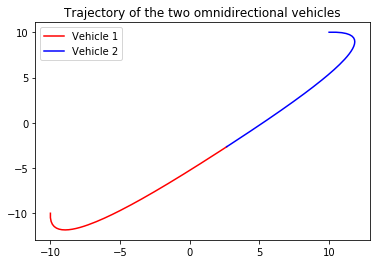

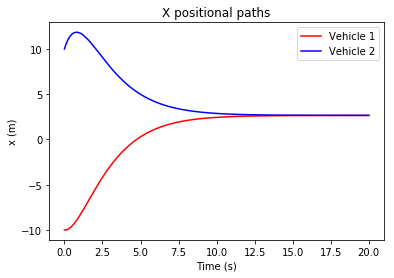

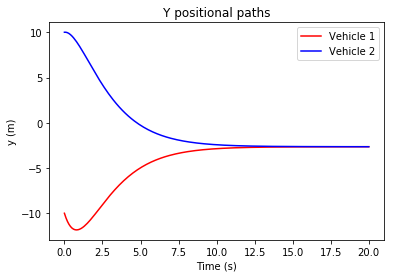

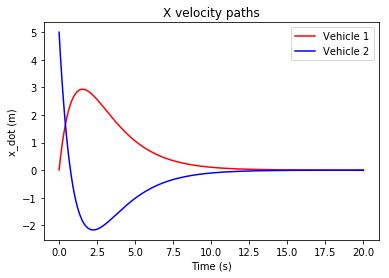

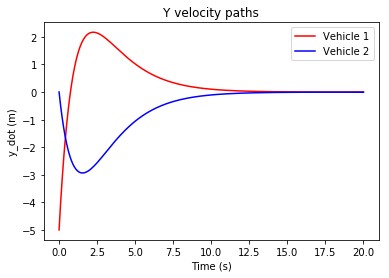

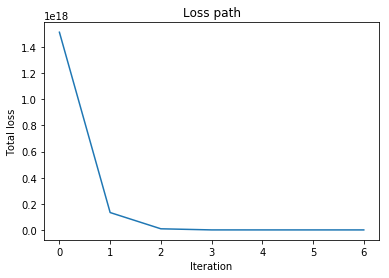

In [13]:
plot(Z, U)

In [14]:
if RENDER:
    # Wait for user interaction before visualizing. 
    _ = input("Press ENTER to continue")

Press ENTER to continue


In [15]:
for u in U:
    env.apply(u)

In [16]:
env.close()